# Introduction



# Notebook Setup

In [1]:
import os
import re
import gc
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Connecting Google Drive for data storage

In [2]:
# Mount Google Drive and confirm access permissions to permitaccess for data located on Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify project directory personal filepaths under Google Drive
user_proj_path = ''

proj_dir = '/content/drive/MyDrive/' + user_proj_path + 'plodi/'
proj_dir_data_raw = proj_dir + 'data/raw/'
proj_dir_data_proc = proj_dir + 'data/processed/'

dirs = [proj_dir, proj_dir_data_raw, proj_dir_data_proc]

for dir in dirs:
    print('-----------------------------------------------------------------------')
    print('Directory contents for ', dir)
    %ls {dir}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-----------------------------------------------------------------------
Directory contents for  /content/drive/MyDrive/plodi/
data/
-----------------------------------------------------------------------
Directory contents for  /content/drive/MyDrive/plodi/data/raw/
2-6%20digit_2017_Codes.xlsx      public_up_to_150k_11_230630.csv  public_up_to_150k_6_230630.csv
2-6%20digit_2022_Codes.xlsx      public_up_to_150k_12_230630.csv  public_up_to_150k_7_230630.csv
6-digit_2017_Codes.xlsx          public_up_to_150k_1_230630.csv   public_up_to_150k_8_230630.csv
6-digit_2022_Codes.xlsx          public_up_to_150k_2_230630.csv   public_up_to_150k_9_230630.csv
ppp-data-dictionary.xlsx         public_up_to_150k_3_230630.csv   sba_ppp_combined.csv
public_150k_plus_230630.csv      public_up_to_150k_4_230630.csv
public_up_to_150k_10_230630.csv  public_up_to_150k_5_230630.csv
-

In [3]:
# drive.mount("/content/drive", force_remount=True) # Run if the Google drive needs to be remounted

# Run after completing Notebook run to gracefully disconnect Gdrive
# drive.flush_and_unmount()

##System Specifications Information

In [4]:
# Check instance specs
!df -h
!cat /proc/cpuinfo
!cat /proc/meminfo

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Filesystem      Size  Used Avail Use% Mounted on
overlay         226G   33G  194G  15% /
tmpfs            64M     0   64M   0% /dev
shm              25G     0   25G   0% /dev/shm
/dev/root       2.0G  1.1G  885M  55% /usr/sbin/docker-init
tmpfs            26G   17M   26G   1% /var/colab
/dev/sda1       233G   37G  196G  16% /etc/hosts
tmpfs            26G     0   26G   0% /proc/acpi
tmpfs            26G     0   26G   0% /proc/scsi
tmpfs            26G     0   26G   0% /sys/firmware
drive           104G   51G   54G  49% /content/drive
processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7B12
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2249.998
cache size	: 512 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb 

In [5]:
#pd.set_option('display.max_columns', None)
#df_ppp_data.head(10)

# Downloading primary data sets

In [24]:
sba_ppp_dict_url = 'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/aab8e9f9-36d1-42e1-b3ba-e59c79f1d7f0/download/ppp-data-dictionary.xlsx'

# Dynamic time-limited URLs for loans requiring SBA.gov queries for project specified date ranges
sba_ppp_url_list = [
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/4b3c3e7a-1286-4883-b857-d37058f9693c/download/public_150k_plus_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/c95195f6-0af6-4b84-8c65-e7cd6b940cc2/download/public_up_to_150k_1_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/eaa51a51-ef19-4c22-affe-61ede7253c6f/download/public_up_to_150k_2_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/eaa51a51-ef19-4c22-affe-61ede7253c6f/download/public_up_to_150k_3_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/b4ec101e-ad78-4a25-a058-ab03b049766b/download/public_up_to_150k_4_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/ea284b67-d0b7-4e65-bc48-663e9bb6dac1/download/public_up_to_150k_5_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/ef56afe8-08f8-4bfa-8a58-29690f5baae0/download/public_up_to_150k_6_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/81f1e2be-28a2-4854-bfe1-1e0d408f9fd0/download/public_up_to_150k_7_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/6ada73a2-8176-4e71-8689-30490d9f8a2f/download/public_up_to_150k_8_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/985f0c28-e799-4940-94a9-96a7c5c604a6/download/public_up_to_150k_9_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/3487edaa-92b3-47f4-b147-06fd6d79f786/download/public_up_to_150k_10_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/3487edaa-92b3-47f4-b147-06fd6d79f786/download/public_up_to_150k_11_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/3487edaa-92b3-47f4-b147-06fd6d79f786/download/public_up_to_150k_12_230630.csv',]


# Setting NAICS data URLs

naics_2017_2to6_digit_url = 'https://www.census.gov/naics/2017NAICS/2-6%20digit_2017_Codes.xlsx'
naics_2017_6_digit_url = 'https://www.census.gov/naics/2017NAICS/6-digit_2017_Codes.xlsx'
naics_2022_2to6_digit_url = 'https://www.census.gov/naics/2022NAICS/2-6%20digit_2022_Codes.xlsx'
naics_2022_6_digit_url = 'https://www.census.gov/naics/2022NAICS/6-digit_2022_Codes.xlsx'

%cd $proj_dir_data_raw # Set working directory for source data download

# Run first time to download SBA PPP data to Google Drive

!curl -O $sba_ppp_dict_url
for url in sba_ppp_url_list:
  !curl -O {url}

# Run first time to download NAICS codes to Google Drive

!curl -O {naics_2017_2to6_digit_url}
!curl -O {naics_2017_6_digit_url}
!curl -O {naics_2022_2to6_digit_url}
!curl -O {naics_2022_6_digit_url}

[Errno 2] No such file or directory: '/content/drive/MyDrive/plodi/data/raw/ # Set working directory for source data download'
/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11834  100 11834    0     0  16484      0 --:--:-- --:--:-- --:--:-- 16481
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6895  100  6895    0     0  12354      0 --:--:-- --:--:-- --:--:-- 12356
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6904  100  6904    0     0  12207      0 --:--:-- --:--:-- --:--:-- 12197
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  S

In [ ]:
!ls

2-6%20digit_2017_Codes.xlsx  public_up_to_150k_10_230630.csv  public_up_to_150k_4_230630.csv
2-6%20digit_2022_Codes.xlsx  public_up_to_150k_11_230630.csv  public_up_to_150k_5_230630.csv
6-digit_2017_Codes.xlsx      public_up_to_150k_12_230630.csv  public_up_to_150k_6_230630.csv
6-digit_2022_Codes.xlsx      public_up_to_150k_1_230630.csv   public_up_to_150k_7_230630.csv
ppp-data-dictionary.xlsx     public_up_to_150k_2_230630.csv   public_up_to_150k_8_230630.csv
public_150k_plus_230630.csv  public_up_to_150k_3_230630.csv   public_up_to_150k_9_230630.csv


In [6]:
# Load individual SBA PPP files
ppp_files_li = [filename for filename in os.listdir(proj_dir_data_raw) if filename.startswith('public_')]
df_ppp_data = pd.concat([pd.read_csv(proj_dir_data_raw+filename, header=0) for filename in ppp_files_li], ignore_index=True)

<ipython-input-6-4c92049d9417>:3: DtypeWarning: Columns (16,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ppp_data = pd.concat([pd.read_csv(proj_dir_data_raw+filename, header=0) for filename in ppp_files_li], ignore_index=True)


In [38]:
# Load SBA PPP data dictionary
filename = 'ppp-data-dictionary.xlsx'
df_ppp_dict = pd.read_excel(proj_dir_data_raw+filename, header=0)

In [39]:
!ls

2-6%20digit_2017_Codes.xlsx  public_up_to_150k_10_230630.csv  public_up_to_150k_5_230630.csv
2-6%20digit_2022_Codes.xlsx  public_up_to_150k_11_230630.csv  public_up_to_150k_6_230630.csv
6-digit_2017_Codes.xlsx      public_up_to_150k_12_230630.csv  public_up_to_150k_7_230630.csv
6-digit_2022_Codes.xlsx      public_up_to_150k_1_230630.csv   public_up_to_150k_8_230630.csv
drive			     public_up_to_150k_2_230630.csv   public_up_to_150k_9_230630.csv
ppp-data-dictionary.xlsx     public_up_to_150k_3_230630.csv   sample_data
public_150k_plus_230630.csv  public_up_to_150k_4_230630.csv


# Preliminary EDA

In [36]:
print(df_ppp_dict.shape, '\n')
display(df_ppp_dict)

(53, 2) 



,Field Name,Field Description
0,LoanNumber,Loan Number (unique identifier)
1,DateApproved,Loan Funded Date
2,SBAOfficeCode,SBA Origination Office Code
3,ProcessingMethod,Loan Delivery Method (PPP for first draw; PPS ...
4,BorrowerName,Borrower Name
5,BorrowerAddress,Borrower Street Address
6,BorrowerCity,Borrower City
7,BorrowerState,Borrower State
8,BorrowerZip,Borrower Zip Code
9,LoanStatusDate,Loan Status Date\n- Loan Status Date is blank...


In [24]:
df_ppp_data.head(4).T

,0,1,2,3
LoanNumber,9595657403,9608808102,9611377305,9620717204
DateApproved,05/20/2020,07/28/2020,05/02/2020,04/28/2020
SBAOfficeCode,1086.0,1086.0,1086.0,1086.0
ProcessingMethod,PPP,PPP,PPP,PPP
BorrowerName,ALIVE & WELL HEALING ARTS,ISHIP EXPRESS LLC,HAIR THERE AND EVERYWHERE LLC,CARRIE DITULLIO REAL ESTATE
BorrowerAddress,1675 SW Marlow Ave,2900 SE CORNELIUS PASS RD STE 101,6220 Lake labish rd ne,1948 Rimrock Rd
BorrowerCity,Portland,HILLSBORO,Salem,BEND
BorrowerState,OR,OR,OR,OR
BorrowerZip,97225-5102,97123-9600,97305-3553,97703
LoanStatusDate,06/08/2021,03/17/2021,03/05/2021,12/17/2020


In [51]:
df_ppp_eda = df_ppp_data.describe(include='all').T
df_ppp_eda['isnull'] = df_ppp_data.isnull().sum(axis = 0)
df_ppp_eda['isna'] = df_ppp_data.isna().sum(axis = 0)
df_ppp_eda['nunique'] = df_ppp_data.nunique(axis = 0)
df_ppp_eda['dtypes'] = df_ppp_data.dtypes

cols = ['count', 'nunique', 'dtypes', 'isnull', 'isna', 'top', 'freq', 'mean',
    'std', 'min', '25%', '50%', '75%', 'max']

df_ppp_eda[cols].style

,count,nunique,dtypes,isnull,isna,top,freq,mean,std,min,25%,50%,75%,max
LoanNumber,11765552.000000,9065552,int64,0,0,nan,nan,5465175977.965923,2569609225.341067,1000007108.000000,3266248810.000000,5449328855.500000,7649957852.000000,9999008900.000000
DateApproved,11765552,246,object,0,0,05/01/2020,796328,nan,nan,nan,nan,nan,nan,nan
SBAOfficeCode,11765524.000000,76,float64,28,28,nan,nan,510.765292,221.917236,101.000000,373.000000,470.000000,593.000000,9030.000000
ProcessingMethod,11765552,2,object,0,0,PPP,8813874,nan,nan,nan,nan,nan,nan,nan
BorrowerName,11765501,7054608,object,51,51,FIRST UNITED METHODIST CHURCH,661,nan,nan,nan,nan,nan,nan,nan
BorrowerAddress,11765352,7401361,object,200,200,PO BOX,706,nan,nan,nan,nan,nan,nan,nan
BorrowerCity,11765367,66601,object,185,185,Miami,158470,nan,nan,nan,nan,nan,nan,nan
BorrowerState,11765387,58,object,165,165,FL,1787943,nan,nan,nan,nan,nan,nan,nan
BorrowerZip,11765375,4025231,object,177,177,00926,8553,nan,nan,nan,nan,nan,nan,nan
LoanStatusDate,11328430,1005,object,437122,437122,03/22/2022,277376,nan,nan,nan,nan,nan,nan,nan


In [41]:
col = 'LoanNumber'
df_ppp_data[df_ppp_data.duplicated(keep=False)].sort_values(by=[col]).T

,9853238,1753238,6276256,876256,3576256,81417,5481417,2781417,3065211,365211,...,971203,689644,3389644,6089644,5431110,31110,2731110,5794046,3094046,394046
LoanNumber,1000007707,1000007707,1000017307,1000017307,1000017307,1000028502,1000028502,1000028502,1000038701,1000038701,...,9998997100,9998998510,9998998510,9998998510,9999008203,9999008203,9999008203,9999008606,9999008606,9999008606
DateApproved,05/01/2020,05/01/2020,04/28/2020,04/28/2020,04/28/2020,02/18/2021,02/18/2021,02/18/2021,03/26/2021,03/26/2021,...,04/15/2020,03/12/2021,03/12/2021,03/12/2021,01/16/2021,01/16/2021,01/16/2021,03/26/2021,03/26/2021,03/26/2021
SBAOfficeCode,455.0,455.0,610.0,610.0,610.0,358.0,358.0,358.0,252.0,252.0,...,341.0,474.0,474.0,474.0,303.0,303.0,303.0,252.0,252.0,252.0
ProcessingMethod,PPP,PPP,PPP,PPP,PPP,PPS,PPS,PPS,PPS,PPS,...,PPP,PPP,PPP,PPP,PPS,PPS,PPS,PPP,PPP,PPP
BorrowerName,ANTIBES INCORPORATED,ANTIBES INCORPORATED,"RED GAP COMMUNICATIONS, INC","RED GAP COMMUNICATIONS, INC","RED GAP COMMUNICATIONS, INC",DAN GOVORA ELECTRICAL CONTRACTORS INC.,DAN GOVORA ELECTRICAL CONTRACTORS INC.,DAN GOVORA ELECTRICAL CONTRACTORS INC.,LEONOR INVESTMENT CORPORATION,LEONOR INVESTMENT CORPORATION,...,"PLAZA MEDICAL ASSOCIATES, LTD",PEYTON BAXTER LLC,PEYTON BAXTER LLC,PEYTON BAXTER LLC,"RETTEW'S CATERING, LLC","RETTEW'S CATERING, LLC","RETTEW'S CATERING, LLC",ELSA FRONTERA,ELSA FRONTERA,ELSA FRONTERA
BorrowerAddress,1781 SW 23RD TER,1781 SW 23RD TER,504 MAIN ST,504 MAIN ST,504 MAIN ST,700 Hidden Trl,700 Hidden Trl,700 Hidden Trl,HERMANOS DAVILA CALLE 3A #142,HERMANOS DAVILA CALLE 3A #142,...,"1600 N. Washington Street, 2nd Floor 2nd floor",109 Center Park Ln,109 Center Park Ln,109 Center Park Ln,309 S Main St,309 S Main St,309 S Main St,702 Calle Martin Guiluz Urb Fair View,702 Calle Martin Guiluz Urb Fair View,702 Calle Martin Guiluz Urb Fair View
BorrowerCity,MIAMI,MIAMI,FORT WORTH,FORT WORTH,FORT WORTH,Greensburg,Greensburg,Greensburg,BAYAMON,BAYAMON,...,Wilmington,Oak Ridge,Oak Ridge,Oak Ridge,Manheim,Manheim,Manheim,San Juan,San Juan,San Juan
BorrowerState,FL,FL,TX,TX,TX,PA,PA,PA,PR,PR,...,DE,TN,TN,TN,PA,PA,PA,PR,PR,PR
BorrowerZip,33145,33145,76102-3925,76102-3925,76102-3925,15601-8316,15601-8316,15601-8316,00959,00959,...,19802,37830-9026,37830-9026,37830-9026,17545-2212,17545-2212,17545-2212,00926-7754,00926-7754,00926-7754
LoanStatusDate,04/22/2021,04/22/2021,02/10/2021,02/10/2021,02/10/2021,09/24/2021,09/24/2021,09/24/2021,03/18/2022,03/18/2022,...,07/08/2021,08/14/2021,08/14/2021,08/14/2021,10/08/2021,10/08/2021,10/08/2021,08/20/2021,08/20/2021,08/20/2021


In [18]:
dtype_dict = {
    'LoanNumber':'uint32', 'SBAOfficeCode':'uint16',
    'ProcessingMethod':'string', 'BorrowerName':'string',
    'BorrowerAddress':'string', 'BorrowerCity':'string',
    'BorrowerState':'string', 'BorrowerZip':'string', 'LoanStatus':'string',
    'Term':'uint8', 'SBAGuarantyPercentage':'uint8',
    'InitialApprovalAmount':'float64', 'CurrentApprovalAmount':'float64',
    'UndisbursedAmount':'float64', 'FranchiseName':'string',
    'ServicingLenderLocationID':'uint32', 'ServicingLenderName':'string',
    'ServicingLenderAddress':'string', 'ServicingLenderCity':'string',
    'ServicingLenderState':'string', 'ServicingLenderZip':'string',
    'RuralUrbanIndicator':'string', 'HubzoneIndicator':'string',
    'LMIIndicator':'string', 'BusinessAgeDescription':'string',
    'ProjectCity':'string', 'ProjectCountyName':'string',
    'ProjectState':'string', 'ProjectZip':'string', 'CD':'string',
    'JobsReported':'uint16', 'NAICSCode':'uint32', 'Race':'string',
    'Ethnicity':'string', 'UTILITIES_PROCEED':'float64',
    'PAYROLL_PROCEED':'float64', 'MORTGAGE_INTEREST_PROCEED':'float64',
    'RENT_PROCEED':'float64', 'REFINANCE_EIDL_PROCEED':'float64',
    'HEALTH_CARE_PROCEED':'float64', 'DEBT_INTEREST_PROCEED':'float64',
    'BusinessType':'string', 'OriginatingLenderLocationID':'uint32',
    'OriginatingLender':'string', 'OriginatingLenderCity':'string',
    'OriginatingLenderState':'string', 'Gender':'string', 'Veteran':'string',
    'NonProfit':'string', 'ForgivenessAmount':'float64'}

parse_dates = ['DateApproved', 'LoanStatusDate', 'ForgivenessDate']

In [ ]:
# Load SBA PPP Data Dictionary into data frame
filename = 'ppp-data-dictionary.xlsx'
df_ppp_dict = pd.read_excel(proj_dir_data_raw+filename, header=0)

# Initial Data Cleaning / Preprocessing

In [7]:
df_ppp_clean = df_ppp_data.copy(deep=True).drop_duplicates()

print('There are', df_ppp_clean['LoanNumber'].nunique(), 'unique loans and',
      df_ppp_clean['LoanNumber'].shape[0], 'total loans after deduplicating',
      'across all columns.')

There are 9065552 unique loans and 9065552 total loans after deduplicating across all columns.


In [8]:
df_ppp_clean['DateApproved'] = pd.to_datetime(df_ppp_clean['DateApproved'])
df_ppp_clean['LoanStatusDate'] = pd.to_datetime(df_ppp_clean['LoanStatusDate'])
df_ppp_clean['ForgivenessDate'] = pd.to_datetime(df_ppp_clean['ForgivenessDate'])

In [9]:
df_ppp_clean.drop(df_ppp_clean.loc[df_ppp_clean['BorrowerName']=='Exemption 6'].index, inplace=True)
df_ppp_clean.drop(df_ppp_clean.loc[df_ppp_clean['BorrowerName'].isnull()==True].index, inplace=True)

In [10]:
df_ppp_eda = df_ppp_clean.describe(include='all').T
df_ppp_eda['isnull'] = df_ppp_clean.isnull().sum(axis = 0)
df_ppp_eda['isna'] = df_ppp_clean.isna().sum(axis = 0)
df_ppp_eda['nunique'] = df_ppp_clean.nunique(axis = 0)
df_ppp_eda['dtypes'] = df_ppp_clean.dtypes

cols = ['count', 'nunique', 'dtypes', 'isnull', 'isna', 'top', 'freq', 'mean',
    'std', 'min', '25%', '50%', '75%', 'max']

df_ppp_eda[cols].style

<ipython-input-10-e7e6bdc53c30>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_ppp_eda = df_ppp_clean.describe(include='all').T
<ipython-input-10-e7e6bdc53c30>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_ppp_eda = df_ppp_clean.describe(include='all').T
<ipython-input-10-e7e6bdc53c30>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_ppp_eda = df_ppp_clean.describe(include='

,count,nunique,dtypes,isnull,isna,top,freq,mean,std,min,25%,50%,75%,max
LoanNumber,9065484.000000,9065484,int64,0,0,nan,nan,5455130888.359578,2570457868.562289,1000007108.000000,3249957252.000000,5442098556.000000,7638361009.000000,9999008900.000000
DateApproved,9065484,246,datetime64[ns],0,0,2020-05-01 00:00:00,623246,nan,nan,nan,nan,nan,nan,nan
SBAOfficeCode,9065484.000000,76,float64,0,0,nan,nan,529.601626,232.350786,101.000000,405.000000,491.000000,679.000000,9030.000000
ProcessingMethod,9065484,2,object,0,0,PPP,6783512,nan,nan,nan,nan,nan,nan,nan
BorrowerName,9065484,7054607,object,0,0,FIRST UNITED METHODIST CHURCH,501,nan,nan,nan,nan,nan,nan,nan
BorrowerAddress,9065324,7401332,object,160,160,PO BOX,498,nan,nan,nan,nan,nan,nan,nan
BorrowerCity,9065334,66601,object,150,150,Chicago,154049,nan,nan,nan,nan,nan,nan,nan
BorrowerState,9065347,58,object,137,137,FL,983253,nan,nan,nan,nan,nan,nan,nan
BorrowerZip,9065338,4025216,object,146,146,10001,3261,nan,nan,nan,nan,nan,nan,nan
LoanStatusDate,8730746,1005,datetime64[ns],334738,334738,2022-03-22 00:00:00,207525,nan,nan,nan,nan,nan,nan,nan


In [13]:
df_ppp_clean.head(5)

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,BusinessType,OriginatingLenderLocationID,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,ForgivenessAmount,ForgivenessDate
0,2593527208,2020-04-16,1094.0,PPP,"LORI L. HOLDER, LCSW",504 MAIN ST Suite 472,LEWISTON,ID,83501-1806,2021-02-24,...,Sole Proprietorship,59698.0,Umpqua Bank,ROSEBURG,OR,Unanswered,Unanswered,NaN,503.92,2021-02-12
1,2741007306,2020-04-29,1087.0,PPP,THUNDER HILL FITNESS CENTER LLC,283 S. Middlefork Rd,GARDEN VALLEY,ID,83622,2021-06-22,...,Limited Liability Partnership,106925.0,Mountain America FCU,SANDY,UT,Unanswered,Unanswered,NaN,505.25,2021-05-25
2,3342508906,2021-04-28,1087.0,PPP,KATRINA RAMIREZ,2877 N Bliss Dr,Idaho Falls,ID,83401-5873,2021-11-11,...,Self-Employed Individuals,317954.0,"Newtek Small Business Finance, Inc.",LAKE SUCCESS,NY,Unanswered,Unanswered,NaN,502.43,2021-10-27
3,3379798208,2020-08-04,1087.0,PPP,JAMES PARIS SCHOOL OF MUSIC,3048 W SAN REMO ST,MERIDIAN,ID,83646-3214,2021-02-03,...,Sole Proprietorship,96211.0,Idaho Central CU,CHUBBUCK,ID,Male Owned,Unanswered,NaN,502.16,2021-01-12
4,3753429003,2021-05-20,1087.0,PPP,ANGEL RICE,4088 S Riva Ridge Way,Boise,ID,83709-4448,2022-03-22,...,Independent Contractors,188361.0,"Prestamos CDFI, LLC",Phoenix,AZ,Female Owned,Non-Veteran,NaN,503.40,2022-02-03


In [14]:
# Export combined SBA PPP files after removal of specified rows
filename = 'sba_ppp_combined.csv'
df_ppp_clean.to_csv(proj_dir_data_raw+filename, index=False)

# Filling NA data to create a clean dataset ready for modeling

In [39]:
df_ppp_merge = df_ppp_clean.copy(deep=True)

# CBSA Data

In [40]:
df_ppp_merge['NAICSCode_2digits'] = df_ppp_merge['NAICSCode'].astype(str).str[:2]

# Create the implied employee pay per year
df_ppp_merge['avg_employee_pay'] = df_ppp_merge['InitialApprovalAmount']/df_ppp_merge['JobsReported'] / 1000 / 2.5 * 12
df_ppp_merge['avg_employee_pay'] = df_ppp_merge['avg_employee_pay'].clip(0, 130)

In [25]:
# Read in the CBSA data and average out the yearly data by state/NAICS codes
filename = 'US_Census_data.xlsx'
cbsa_data = pd.read_excel(proj_dir_data_raw+filename, header=0)
census_grouped = cbsa_data.groupby(['State_AB','NAICS Code'])['Average annual payroll ($1,000)'].mean().reset_index()
census_grouped['NAICS Code'] = census_grouped['NAICS Code'].astype(str)

In [26]:
cbsa_data.head(5)

,State FIPS,State,118th Congressional District,2017 NAICS Code,NAICS Description,Number of Establishments,Employment,Employment Noise Flag,"1st Quarter Payroll ($1,000)",1st Quarter Payroll Noise Flag,"Annual Payroll ($1,000)",Annual Payroll Noise Flag,Year,"Average annual payroll ($1,000)",State_AB,NAICS Code
0,1,Alabama,1,11----,"Agriculture, forestry, fishing and hunting",132,937,G,10051,G,45283,G,2021,48.327641,AL,11
1,1,Alabama,1,21----,"Mining, quarrying, and oil and gas extraction",26,295,H,6001,G,23476,G,2021,79.579661,AL,21
2,1,Alabama,1,22----,Utilities,46,1383,G,45594,H,148906,H,2021,107.668836,AL,22
3,1,Alabama,1,23----,Construction,1533,17390,G,214351,G,965591,G,2021,55.525647,AL,23
4,1,Alabama,1,31----,Manufacturing,572,25471,G,438931,G,1858642,G,2021,72.970908,AL,31


In [41]:
census_grouped.isnull().sum(axis=0)

State_AB                           0
NAICS Code                         0
Average annual payroll ($1,000)    0
dtype: int64

In [42]:
df_ppp_merge = df_ppp_merge.merge(census_grouped, left_on = ['BorrowerState','NAICSCode_2digits'], right_on = ['State_AB','NAICS Code'], how = 'left')
df_ppp_merge.head(5)

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,Gender,Veteran,NonProfit,ForgivenessAmount,ForgivenessDate,NAICSCode_2digits,avg_employee_pay,State_AB,NAICS Code,"Average annual payroll ($1,000)"
0,2593527208,2020-04-16,1094.0,PPP,"LORI L. HOLDER, LCSW",504 MAIN ST Suite 472,LEWISTON,ID,83501-1806,2021-02-24,...,Unanswered,Unanswered,NaN,503.92,2021-02-12,62,2.40,ID,62,48.484265
1,2741007306,2020-04-29,1087.0,PPP,THUNDER HILL FITNESS CENTER LLC,283 S. Middlefork Rd,GARDEN VALLEY,ID,83622,2021-06-22,...,Unanswered,Unanswered,NaN,505.25,2021-05-25,71,1.20,ID,71,20.598719
2,3342508906,2021-04-28,1087.0,PPP,KATRINA RAMIREZ,2877 N Bliss Dr,Idaho Falls,ID,83401-5873,2021-11-11,...,Unanswered,Unanswered,NaN,502.43,2021-10-27,42,2.40,ID,42,68.046392
3,3379798208,2020-08-04,1087.0,PPP,JAMES PARIS SCHOOL OF MUSIC,3048 W SAN REMO ST,MERIDIAN,ID,83646-3214,2021-02-03,...,Male Owned,Unanswered,NaN,502.16,2021-01-12,81,2.40,ID,81,31.484254
4,3753429003,2021-05-20,1087.0,PPP,ANGEL RICE,4088 S Riva Ridge Way,Boise,ID,83709-4448,2022-03-22,...,Female Owned,Non-Veteran,NaN,503.40,2022-02-03,49,2.40,NaN,NaN,NaN
5,3955459010,2021-05-20,1087.0,PPP,CHRISTOPHER STRICKLAND,566 Chastain Dr Apt 3,Chubbuck,ID,83202-2507,2022-03-22,...,Male Owned,Veteran,NaN,502.82,2021-12-23,49,2.40,NaN,NaN,NaN
6,3987777406,2020-05-08,1087.0,PPP,DOUG GASKILL PHOTOGRAPHY,3155 E 3200 N,TWIN FALLS,ID,83301,2021-05-22,...,Unanswered,Non-Veteran,NaN,504.53,2021-04-08,54,1.20,ID,54,66.216613
7,4103877804,2020-05-27,1087.0,PPP,SEA SCAPES SALT CAVES,2577 South Five Mile Road,Boise,ID,83709-2325,2022-03-09,...,Unanswered,Unanswered,NaN,506.82,2021-10-13,71,17.76,ID,71,20.598719
8,4262528002,2020-06-25,1087.0,PPP,"TULLOCH ACCOUNTING, LLC","1123 12th Avenue Road, #115",Nampa,ID,83686,2021-02-02,...,Unanswered,Unanswered,NaN,503.05,2021-02-12,54,2.40,ID,54,66.216613
9,5367128208,2020-08-07,1087.0,PPP,CRYSTAL CLEAN CARPET CLEANING,535 ANGELA DR,REXBURG,ID,83440-1420,2022-03-09,...,Unanswered,Unanswered,NaN,503.75,2021-05-13,56,1.20,ID,56,37.418678


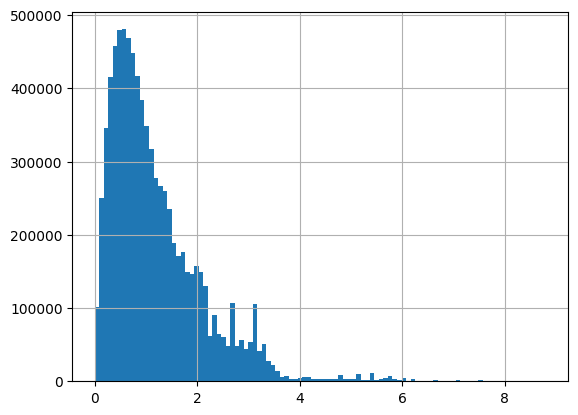

In [43]:
# Create average pay ration to NAICS data and truncate values
df_ppp_merge['pay_ratio'] = df_ppp_merge['avg_employee_pay']/df_ppp_merge['Average annual payroll ($1,000)']
df_ppp_merge.pay_ratio.hist(bins=100)
df_ppp_merge['pay_ratio'] = df_ppp_merge['pay_ratio'].clip(0, 10)
#df_ppp_merge.pay_ratio.hist(bins=100)
#df_ppp_merge.avg_employee_pay.hist(bins=100)
#df_ppp_merge.head()

##USPS Data

In [44]:
filename = 'LoanNumber_USPS_GEOID.csv'
df_usps = pd.read_csv(proj_dir_data_proc+filename, header=0)

<ipython-input-44-34f34246841e>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_usps = pd.read_csv(proj_dir_data_proc+filename, header=0)


In [50]:
print(df_usps.USPSAPI_Result.value_counts(dropna=False), '\n',
      df_usps.columns.tolist())

 USPSAPI_Result: True                                           8900287
NaN                                                             2020602
 USPSAPI_Result: More Information Needed to Validate Address     844663
Name: USPSAPI_Result, dtype: int64 
 ['Unnamed: 0', 'LoanNumber', 'USPSAPI_Result', 'GEOID20', 'GEOID']


In [51]:
# Set verified to be 1 and all else to 0

df_ppp_merge['Verified_Address'] = df_usps['USPSAPI_Result'].map({' USPSAPI_Result: True': 1, ' USPSAPI_Result: More Information Needed to Validate Address': 0}).fillna(0)
df_ppp_merge.Verified_Address.value_counts(dropna=False)

1.0    7619447
0.0    1446037
Name: Verified_Address, dtype: int64

# Check

In [53]:
df_ppp_merge.isnull().sum()

LoanNumber                               0
DateApproved                             0
SBAOfficeCode                            0
ProcessingMethod                         0
BorrowerName                             0
BorrowerAddress                        160
BorrowerCity                           150
BorrowerState                          137
BorrowerZip                            146
LoanStatusDate                      334738
LoanStatus                               0
Term                                     0
SBAGuarantyPercentage                    0
InitialApprovalAmount                    0
CurrentApprovalAmount                    0
UndisbursedAmount                      917
FranchiseName                      8940411
ServicingLenderLocationID                0
ServicingLenderName                      0
ServicingLenderAddress                   0
ServicingLenderCity                      0
ServicingLenderState                     0
ServicingLenderZip                       0
RuralUrbanI

In [21]:
df_ppp_clean[df_ppp_clean['JobsReported'].isnull()==True].T

,1375594,2202718,4440560,8104390,8745629
LoanNumber,5701187705,4361697300,4591847205,5000227200,4953687704
DateApproved,2020-05-03 00:00:00,2020-04-29 00:00:00,2020-04-27 00:00:00,2020-04-27 00:00:00,2020-05-03 00:00:00
SBAOfficeCode,101.0,709.0,1086.0,353.0,912.0
ProcessingMethod,PPP,PPP,PPP,PPP,PPP
BorrowerName,AMR CLOTHING COMPANY,BALDCONN LLC,HANUMAN MANAGEMENT INC,SHENANDOAH TRADING COMPANY,"VICTORY OUTREACH SAN JOSE, INC"
BorrowerAddress,9 WATER ST,526 SE 400TH RD,201 NE 3rd,15014 BANKFIELD DR,590 SHAWNEE LANE
BorrowerCity,BOSTON,WARRENSBURG,BEND,WATERFORD,SAN JOSE
BorrowerState,MA,MO,OR,VA,CA
BorrowerZip,02109-4506,64093-8315,97701-4915,20197-1267,95123
LoanStatusDate,2021-07-22 00:00:00,2021-08-11 00:00:00,2021-03-03 00:00:00,2021-03-12 00:00:00,NaT


In [19]:
fillna_dict = {
    'BusinessAgeDescription': 'Unanswered',
    'ProjectCity': 'N/A',
    'ProjectCountyName': 'N/A',
    'ProjectState': 'NA',
    'ProjectZip': 'N/A',
    'CD': 'NA-00'}

df.fillna(value=fillnadict)




,8088257
LoanNumber,5600828301
DateApproved,2021-01-25 00:00:00
SBAOfficeCode,883.0
ProcessingMethod,PPS
BorrowerName,MAC'S MINING REPAIR SERVICE INC.
BorrowerAddress,PO BOX 480
BorrowerCity,HUNTINGTON
BorrowerState,UT
BorrowerZip,84528-0480
LoanStatusDate,2021-07-28 00:00:00


In [ ]:
df_ppp_clean.set_index(['LoanNumber'])

In [20]:
fillna_dict = {"A": 0, "B": 1, "C": 2, "D": 3}

df.fillna(value=values)

NameError: ignored

In [3]:
cols = [
 'DateApproved',
 'SBAOfficeCode',
 'ProcessingMethod',
 'BorrowerName',
 'BorrowerAddress',
 'BorrowerCity',
 'BorrowerState',
 'BorrowerZip',
 'LoanStatusDate',
 'LoanStatus',
 'Term',
 'SBAGuarantyPercentage',
 'InitialApprovalAmount',
 'CurrentApprovalAmount',
 'UndisbursedAmount',
 'FranchiseName',
 'ServicingLenderLocationID',
 'ServicingLenderName',
 'ServicingLenderAddress',
 'ServicingLenderCity',
 'ServicingLenderState',
 'ServicingLenderZip',
 'RuralUrbanIndicator',
 'HubzoneIndicator',
 'LMIIndicator',
 'BusinessAgeDescription',
 'ProjectCity',
 'ProjectCountyName',
 'ProjectState',
 'ProjectZip',
 'CD',
 'JobsReported',
 'NAICSCode',
 'Race',
 'Ethnicity',
 'UTILITIES_PROCEED',
 'PAYROLL_PROCEED',
 'MORTGAGE_INTEREST_PROCEED',
 'RENT_PROCEED',
 'REFINANCE_EIDL_PROCEED',
 'HEALTH_CARE_PROCEED',
 'DEBT_INTEREST_PROCEED',
 'BusinessType',
 'OriginatingLenderLocationID',
 'OriginatingLender',
 'OriginatingLenderCity',
 'OriginatingLenderState',
 'Gender',
 'Veteran',
 'NonProfit',
 'ForgivenessAmount',
 'ForgivenessDate']

ax = df_ppp_clean.plot.hist(column=['For'], bins=10, alpha=0.5)

NameError: ignored

# Load Final Processed Data Set

In [ ]:
filename = 'sba_ppp_combined.csv'

# Load SBA PPP files into data frame from combined file
df_ppp_data = pd.read_csv(proj_dir_data_raw+filename, header=0)

In [ ]:
# Set of cols to use on working modeling data file

usecols = ['LoanNumber',
 'Term',
 'InitialApprovalAmount',
 'CurrentApprovalAmount',
 'UndisbursedAmount',
 'JobsReported',
 'NAICSCode',
 'UTILITIES_PROCEED',
 'PAYROLL_PROCEED',
 'MORTGAGE_INTEREST_PROCEED',
 'RENT_PROCEED',
 'REFINANCE_EIDL_PROCEED',
 'HEALTH_CARE_PROCEED',
 'DEBT_INTEREST_PROCEED',
 'ForgivenessAmount',
 'ProcessingMethod_cat',
 'LoanStatus_cat',
 'RuralUrbanIndicator_cat',
 'HubzoneIndicator_cat',
 'LMIIndicator_cat',
 'Race_cat',
 'Ethnicity_cat',
 'BusinessType_cat',
 'Gender_cat',
 'Veteran_cat',
 'NonProfit_cat',
 'Verified_Address',
 'avg_employee_pay',
 'pay_ratio',
 'pay_ratio_binary',
 'pay_100k',
#  'Fraud',
 'Labelled_Loan_Binary']

dtype_dict = {'LoanNumber': np.uint,
 'Term': np.intc,
 'InitialApprovalAmount': np.single,
 'CurrentApprovalAmount': np.single,
 'UndisbursedAmount': np.single,
 'JobsReported': np.intc,
 'NAICSCode': np.intc,
 'UTILITIES_PROCEED': np.single,
 'PAYROLL_PROCEED': np.single,
 'MORTGAGE_INTEREST_PROCEED': np.single,
 'RENT_PROCEED': np.single,
 'REFINANCE_EIDL_PROCEED': np.single,
 'HEALTH_CARE_PROCEED': np.single,
 'DEBT_INTEREST_PROCEED': np.single,
 'ForgivenessAmount': np.single,
 'ProcessingMethod_cat': np.byte,
 'LoanStatus_cat': np.byte,
 'RuralUrbanIndicator_cat': np.byte,
 'HubzoneIndicator_cat': np.byte,
 'LMIIndicator_cat': np.byte,
 'Race_cat': np.byte,
 'Ethnicity_cat': np.byte,
 'BusinessType_cat': np.byte,
 'Gender_cat': np.byte,
 'Veteran_cat': np.byte,
 'NonProfit_cat': np.byte,
 'Verified_Address': np.byte,
 'avg_employee_pay': np.single,
 'pay_ratio': np.single,
 'pay_ratio_binary': np.byte,
 'pay_100k': np.byte,
#  'Fraud': np.byte,
 'Labelled_Loan_Binary': np.byte}

index_col = 'LoanNumber'

# filepath = 's3://sagemaker-us-west-1-945035589481/modelling_data.csv'
filename = 'modelling_data.csv'
filepath = proj_dir_data_proc+filename
df_data = pd.read_csv(filepath, header=0, index_col=index_col, usecols=usecols, dtype=dtype_dict)

In [ ]:
df_data.columns.tolist()

['Term',
 'InitialApprovalAmount',
 'CurrentApprovalAmount',
 'UndisbursedAmount',
 'JobsReported',
 'NAICSCode',
 'UTILITIES_PROCEED',
 'PAYROLL_PROCEED',
 'MORTGAGE_INTEREST_PROCEED',
 'RENT_PROCEED',
 'REFINANCE_EIDL_PROCEED',
 'HEALTH_CARE_PROCEED',
 'DEBT_INTEREST_PROCEED',
 'ForgivenessAmount',
 'ProcessingMethod_cat',
 'LoanStatus_cat',
 'RuralUrbanIndicator_cat',
 'HubzoneIndicator_cat',
 'LMIIndicator_cat',
 'Race_cat',
 'Ethnicity_cat',
 'BusinessType_cat',
 'Gender_cat',
 'Veteran_cat',
 'NonProfit_cat',
 'Verified_Address',
 'avg_employee_pay',
 'pay_ratio',
 'pay_ratio_binary',
 'pay_100k',
 'Labelled_Loan_Binary']

In [ ]:
print('\n\nLoan Number # of NA \n', df_data.isnull().sum(axis = 0))



Loan Number # of NA 
 Term                         0
InitialApprovalAmount        0
CurrentApprovalAmount        0
UndisbursedAmount            0
JobsReported                 0
NAICSCode                    0
UTILITIES_PROCEED            0
PAYROLL_PROCEED              0
MORTGAGE_INTEREST_PROCEED    0
RENT_PROCEED                 0
REFINANCE_EIDL_PROCEED       0
HEALTH_CARE_PROCEED          0
DEBT_INTEREST_PROCEED        0
ForgivenessAmount            0
ProcessingMethod_cat         0
LoanStatus_cat               0
RuralUrbanIndicator_cat      0
HubzoneIndicator_cat         0
LMIIndicator_cat             0
Race_cat                     0
Ethnicity_cat                0
BusinessType_cat             0
Gender_cat                   0
Veteran_cat                  0
NonProfit_cat                0
Verified_Address             0
avg_employee_pay             0
pay_ratio                    0
pay_ratio_binary             0
pay_100k                     0
Labelled_Loan_Binary         0
dtype: int64


In [ ]:
np.isinf(df_data).values.sum()

0

In [ ]:
df_data.head(5)

,Term,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,JobsReported,NAICSCode,UTILITIES_PROCEED,PAYROLL_PROCEED,MORTGAGE_INTEREST_PROCEED,RENT_PROCEED,...,BusinessType_cat,Gender_cat,Veteran_cat,NonProfit_cat,Verified_Address,avg_employee_pay,pay_ratio,pay_ratio_binary,pay_100k,Labelled_Loan_Binary
LoanNumber,,,,,,,,,,,,,,,,,,,,,
3383618704,60,13540.000000,13540.000000,0.0,1,51,1.0,13538.000000,0.0,0.0,...,20,1,0,0,0,64.991997,0.909467,0,0,0
5776278404,60,6205.399902,6205.399902,0.0,1,62,0.0,6205.399902,0.0,0.0,...,18,2,1,0,1,29.785919,0.609532,0,0,0
5966978904,60,27900.000000,27900.000000,0.0,4,23,1.0,27898.000000,0.0,0.0,...,21,2,1,0,1,33.480000,0.570875,0,0,0
9647148304,60,68307.000000,68307.000000,0.0,7,33,1.0,68304.000000,0.0,0.0,...,5,1,0,0,0,46.839085,1.000000,0,0,0
3136537210,24,8700.000000,8700.000000,0.0,1,81,0.0,8700.000000,0.0,0.0,...,5,2,1,0,0,41.759998,1.497966,0,0,0


In [ ]:
df_data.describe

<bound method NDFrame.describe of             Term  InitialApprovalAmount  CurrentApprovalAmount  \
LoanNumber                                                       
3383618704    60           1.354000e+04           1.354000e+04   
5776278404    60           6.205400e+03           6.205400e+03   
5966978904    60           2.790000e+04           2.790000e+04   
9647148304    60           6.830700e+04           6.830700e+04   
3136537210    24           8.700000e+03           8.700000e+03   
...          ...                    ...                    ...   
7368587102    24           3.420000e+04           4.380000e+04   
5355747104    24           2.820000e+04           2.820000e+04   
6463348808    60           2.079100e+04           2.079100e+04   
6414248501    60           2.083250e+04           2.083250e+04   
6749737207    24           1.018847e+06           1.018847e+06   

            UndisbursedAmount  JobsReported  NAICSCode  UTILITIES_PROCEED  \
LoanNumber                    

In [ ]:
print(df_data.min(axis=0))
print(df_data.max(axis=0))

Term                              0.0
InitialApprovalAmount       -199659.0
CurrentApprovalAmount             0.0
UndisbursedAmount                 0.0
JobsReported                     -6.0
NAICSCode                        10.0
UTILITIES_PROCEED                 0.0
PAYROLL_PROCEED                   0.0
MORTGAGE_INTEREST_PROCEED         0.0
RENT_PROCEED                      0.0
REFINANCE_EIDL_PROCEED            0.0
HEALTH_CARE_PROCEED               0.0
DEBT_INTEREST_PROCEED             0.0
ForgivenessAmount                 0.0
ProcessingMethod_cat              0.0
LoanStatus_cat                    0.0
RuralUrbanIndicator_cat           0.0
HubzoneIndicator_cat              0.0
LMIIndicator_cat                  0.0
Race_cat                          0.0
Ethnicity_cat                     0.0
BusinessType_cat                  0.0
Gender_cat                        0.0
Veteran_cat                       0.0
NonProfit_cat                     0.0
Verified_Address                  0.0
avg_employee

In [ ]:
for label in df_data.columns.tolist():
  print(label, ': ', df_data[label].dtype)

Term :  int32
InitialApprovalAmount :  float32
CurrentApprovalAmount :  float32
UndisbursedAmount :  float32
JobsReported :  int32
NAICSCode :  int32
UTILITIES_PROCEED :  float32
PAYROLL_PROCEED :  float32
MORTGAGE_INTEREST_PROCEED :  float32
RENT_PROCEED :  float32
REFINANCE_EIDL_PROCEED :  float32
HEALTH_CARE_PROCEED :  float32
DEBT_INTEREST_PROCEED :  float32
ForgivenessAmount :  float32
ProcessingMethod_cat :  int8
LoanStatus_cat :  int8
RuralUrbanIndicator_cat :  int8
HubzoneIndicator_cat :  int8
LMIIndicator_cat :  int8
Race_cat :  int8
Ethnicity_cat :  int8
BusinessType_cat :  int8
Gender_cat :  int8
Veteran_cat :  int8
NonProfit_cat :  int8
Verified_Address :  int8
avg_employee_pay :  float32
pay_ratio :  float32
pay_ratio_binary :  int8
pay_100k :  int8
Labelled_Loan_Binary :  int8


# PyOD XGBOD

In [ ]:
from pyod.models.xgbod import XGBOD

In [ ]:
label_col = 'Labelled_Loan_Binary'
test_size = 0.1
train_size = 0.1
random_state = 21

clf_name = 'XGBOD'
contamination = 0.08

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_data.drop(['Labelled_Loan_Binary'], axis=1), df_data['Labelled_Loan_Binary'],
                                                    test_size=test_size, train_size=train_size, random_state=random_state, stratify=df_data['Labelled_Loan_Binary'].values)

In [ ]:
clf = XGBOD(random_state=random_state, silent=0)
clf.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:14:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGBOD(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1,
   estimator_list=[KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2,
  radius=1.0), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=1, no...x_features=1.0,
    max_samples='auto', n_estimators=200, n_jobs=1, random_state=21,
    verbose=0)],
   gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
   min_child_weight=1, n_estimators=100, n_jobs=1, nthread=None,
   objective='binary:logistic', random_state=21, reg_alpha=0, reg_lambda=1,
   scale_pos_weight=1, silent=0,
   standardization_flag_list=[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, Fal

In [ ]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [ ]:
np.sum(y_train)
np.sum(y_train_pred)

In [ ]:
# evaluate and print the results
print('Training Data:')
evaluate_print(clf_name, y_train, y_train_scores)

Training Data:
XGBOD ROC:0.9994, precision @ rank n:0.9667


In [ ]:
y_test_pred = clf.predict(X_test)

In [ ]:
y_test_scores = clf.decision_function(X_test)

In [ ]:
np.sum(y_test_pred)

0

In [ ]:
out_results = X_test.copy(deep=True)

In [ ]:
out_results['y_test_pred'] = y_test_pred.tolist()
out_results['y_test_scores'] = y_test_scores.tolist()

In [ ]:
out_results.to_csv(proj_dir_data_proc+'test-run-data.csv')

In [ ]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The test data:", count_stat(y_test_pred))

In [ ]:
clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'estimator_list': [KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=1, n_neighbors=1, novelty=True, p=2),
  KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=3, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=1, n_neighbors=3, novelty=True, p=2),
  KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, 

# XGBOD Downsampled

In [ ]:
label_col = 'Labelled_Loan_Binary'
test_size = 0.2
train_size = 0.8
random_state = 21

clf_name = 'XGBOD'
contamination = 0.08
n_jobs = -1

In [ ]:
n_samples = math.ceil(
    df_data.loc[df_data['Labelled_Loan_Binary'] == 1].shape[0] / contamination)

df_downsampled = resample(
    df_data.loc[df_data['Labelled_Loan_Binary'] == 0], replace=False,
    n_samples=n_samples, random_state=random_state)

df_downsampled = pd.concat([df_downsampled, df_data.loc[df_data['Labelled_Loan_Binary'] == 1]], ignore_index=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_downsampled.drop(['Labelled_Loan_Binary'], axis=1), df_downsampled['Labelled_Loan_Binary'],
                                                    test_size=test_size, train_size=train_size, random_state=random_state, stratify=df_downsampled['Labelled_Loan_Binary'].values)

In [ ]:
clf = XGBOD(random_state=random_state, contamination=contamination, silent=False, n_jobs = n_jobs)
clf.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:35:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "contamination", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGBOD(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1,
   estimator_list=[KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2,
  radius=1.0), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=1, no...x_features=1.0,
    max_samples='auto', n_estimators=200, n_jobs=1, random_state=21,
    verbose=0)],
   gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
   min_child_weight=1, n_estimators=100, n_jobs=-1, nthread=None,
   objective='binary:logistic', random_state=21, reg_alpha=0, reg_lambda=1,
   scale_pos_weight=1, silent=False,
   standardization_flag_list=[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False

In [ ]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# evaluate and print the results
print('Training Data:')
evaluate_print(clf_name, y_train, y_train_scores)

Training Data:
XGBOD ROC:0.9264, precision @ rank n:0.6246


In [ ]:
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)
# evaluate and print the results
print('Training Data:')
evaluate_print(clf_name, y_test, y_test_scores)

Training Data:
XGBOD ROC:0.8335, precision @ rank n:0.5267


In [ ]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The test data:", count_stat(y_test_pred))

The training data: {0: 7848, 1: 273}
The test data: {0: 1964, 1: 67}


In [ ]:
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9557    0.9979    0.9763      1881
           1     0.9403    0.4200    0.5806       150

    accuracy                         0.9552      2031
   macro avg     0.9480    0.7089    0.7785      2031
weighted avg     0.9546    0.9552    0.9471      2031



In [ ]:
clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'estimator_list': [KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=1, n_neighbors=1, novelty=True, p=2),
  KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=3, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=1, n_neighbors=3, novelty=True, p=2),
  KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, 